Hi, Sarah! This first tutorial will create three files, each representing a mock physical realization of a stellar population, some of which have planets. We're going to do this with the Berger+20 Gaia-Kepler sample (hereafter B20), as well as a TRILEGAL sample. 

Tunable parameters in this notebook include:
- planet host fraction
- initial intact fraction
- current intact fraction
- threshold of intact fraction change

There's other stuff you can prescribe, like what distribution to use for intact vs disrupted, but we're going to keep things as simple as possible here. 

In [67]:
!pip3 install psps

In [12]:
# mise en place
import os
import os.path
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import random
from tqdm import tqdm

from psps.transit_class import Population, Star
import psps.simulate_helpers as simulate_helpers
import psps.utils as utils

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

matplotlib.rcParams.update({'errorbar.capsize': 1})
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

path = '/Users/chrislam/Desktop/psps/' # change path here to yours

#berger_kepler = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv') # B20 crossmatched with Gaia via Bedell
#berger_kepler_m = pd.read_csv(path+'data/berger_kepler_stellar_m.csv') # I have this if you ever need it

"""
### This is how we enriched the B20 sample with height, by way of gaia source_id 
# Berger+ 2020 sample has lots of stellar params we need, but no source_id
berger = Table.read(path+'data/berger_kepler_stellar_fgk.csv')
# Bedell cross-match has the Gaia DR3 source_id we need to calculate Zmax with Gala
megan = Table.read(path+'data/kepler_dr3_good.fits')
megan_df = megan.to_pandas()
megan_m = megan_df.loc[(megan_df['teff'] <= 4000) & (megan_df['teff'] >= 2300)]

# cross-match the cross-matches (we only lose ~100 stars)
merged = join(berger, megan, keys='kepid')
merged.rename_column('parallax_2', 'parallax')
berger_kepler = berger_kepler.loc[berger_kepler['kepid'].isin(merged['kepid'])]
# enrich berger_kepler with z_maxes using gala
z_maxes = simulate_helpers.gala_galactic_heights(merged, output=False)
berger_kepler['height'] = 1000 * np.array(z_maxes) # kpc
berger_kepler.to_csv(path+'data/berger_kepler_bedell_gala.csv', index=False)
"""

berger_kepler = pd.read_csv(path+'data/berger_kepler_bedell_gala.csv') # now with gala heights!

datpaths = [
                os.path.join(path, 'data/trilegal_kepler_thick1.dat'),
                os.path.join(path, 'data/trilegal_kepler_thick2.dat'),
                os.path.join(path, 'data/trilegal_kepler_thick3.dat'),
                os.path.join(path, 'data/trilegal_kepler_thick4.dat'),
                os.path.join(path, 'data/trilegal_kepler_thick5.dat'),
                os.path.join(path, 'data/trilegal_kepler_thick6.dat')
            ]

trilegal_kepler = pd.concat((pd.read_csv(f, sep='\s+') for f in datpaths)) # 120K stars
trilegal_kepler = trilegal_kepler.loc[trilegal_kepler['m2/m1']==0.].reset_index() # eliminate binaries: 70K stars 
trilegal_kepler['Teff'] = 10**trilegal_kepler['logTe'].astype(float)
#trilegal_kepler = trilegal_kepler.loc[(10**trilegal_kepler['logTe'] <= 7500) & (10**trilegal_kepler['logTe'] >= 3700)] # outside of this range, we stop resembling Kepler: 60K stars

# TRILEGAL logAge bin size is 0.02, so let's introduce a spread of that size; note from Luke Bouma (https://github.com/lgbouma/gyrojo/blob/main/gyrojo/trilegal.py#L92-L108)
eps = np.random.normal(loc=0, scale=0.02, size=len(trilegal_kepler))
trilegal_kepler['logAge'] = trilegal_kepler['logAge'].astype(float)
trilegal_kepler['logAge'] += eps

trilegal_kepler['age'] = 10**trilegal_kepler['logAge'] / 1e9

# enrich with other columns required for transit detection forward modeling
trilegal_kepler['stellar_radius'] = simulate_helpers.stellar_radius_stefan_boltzmann(10**trilegal_kepler['logTe'], 10**trilegal_kepler['logL'])

# m-M0 has scale of 0.05 dex.
eps = np.random.normal(loc=0, scale=0.05, size=len(trilegal_kepler))
trilegal_kepler['m-M0'] += eps
trilegal_kepler['distance_pc'] = 10 * 10**(trilegal_kepler['m-M0']/5)

trilegal_kepler['distance'] = simulate_helpers.distance_modulus_to_distance(trilegal_kepler['m-M0'], perturb=True)
trilegal_kepler['height'] = simulate_helpers.dist_kepler_to_height(trilegal_kepler['distance']) 
print(len(trilegal_kepler))

### draw CDPP for TRILEGAL sample, matched to Teff/logg/kepmag bins, to make sure its distribution is similar to that of B20 sample
#trilegal_kepler = simulate_helpers.kepmag_to_cdpp_vectorized(berger_kepler, trilegal_kepler) 

berger_kepler['frac_age_err1'] = berger_kepler['iso_age_err1']/berger_kepler['iso_age']
berger_kepler['frac_age_err2'] = berger_kepler['iso_age_err2']/berger_kepler['iso_age']
print(np.nanmedian(berger_kepler['frac_age_err1']))
print(np.nanmedian(berger_kepler['frac_age_err2']))


<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\s'
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_63018/2587699632.py:62: SyntaxWarning: invalid escape sequence '\s'
  trilegal_kepler = pd.concat((pd.read_csv(f, sep='\s+') for f in datpaths)) # 120K stars
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_63018/2587699632.py:51: DtypeWarning: Columns (138) have mixed types. Specify dtype option on import or set low_memory=False.
  berger_kepler = pd.read_csv(path+'data/berger_kepler_bedell_gala.csv') # now with gala heights!


104691
0.31531531531531526
-0.2783059636992221


median age for 3000-4000 K:  3.603503782587679
median age for 4000-5000 K:  4.952229450763529
median age for 5000-7000 K:  3.4698263940042446


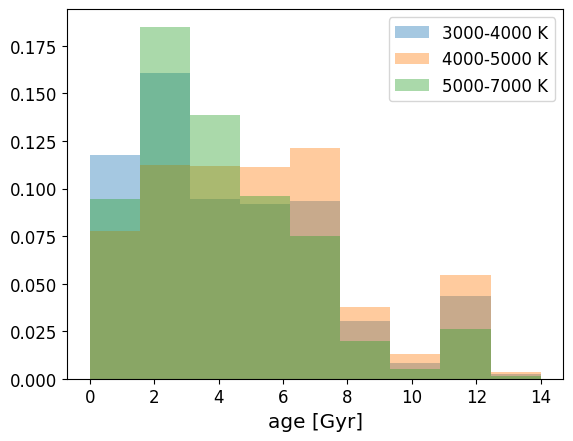

In [16]:
cool = trilegal_kepler.loc[(trilegal_kepler['Teff'] <= 4000) & (trilegal_kepler['Teff'] > 3000)]
medium = trilegal_kepler.loc[(trilegal_kepler['Teff'] <= 5000) & (trilegal_kepler['Teff'] > 4000)]
hot = trilegal_kepler.loc[(trilegal_kepler['Teff'] <= 7000) & (trilegal_kepler['Teff'] > 5000)]
#trilegal_kepler.loc[trilegal_kepler['logg'] <= 4]
print("median age for 3000-4000 K: ", np.nanmedian(cool.age))
print("median age for 4000-5000 K: ", np.nanmedian(medium.age))
print("median age for 5000-7000 K: ", np.nanmedian(hot.age))

plt.hist(cool['age'], density=True, alpha=0.4, label='3000-4000 K', bins=np.linspace(0, 14, 10))
plt.hist(medium['age'], density=True, alpha=0.4, label='4000-5000 K', bins=np.linspace(0, 14, 10))
plt.hist(hot['age'], density=True, alpha=0.4, label='5000-7000 K', bins=np.linspace(0, 14, 10))
plt.xlabel('age [Gyr]')
plt.legend()
plt.show()

median Teff:  6151.7687270986835
median age:  3.1482030218731722


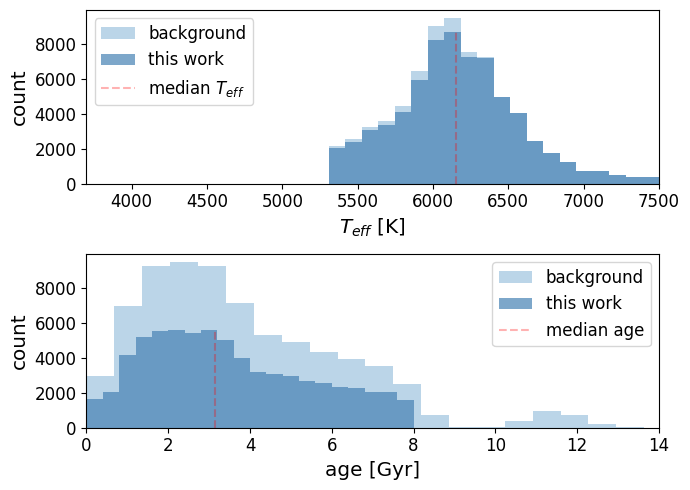

median Teff:  6039.5
median age:  3.89


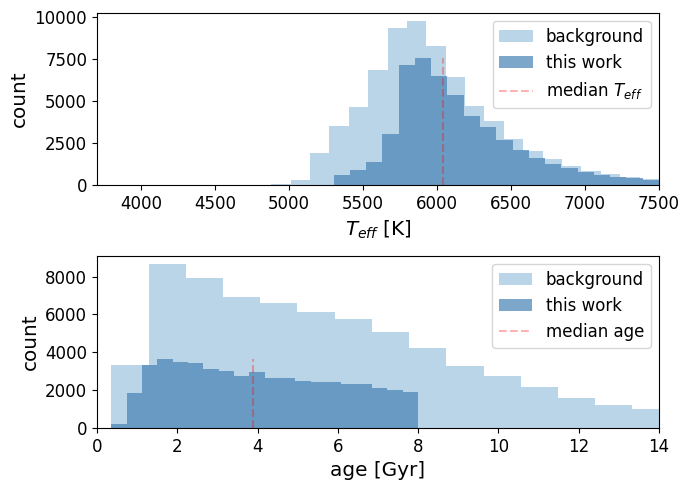

In [11]:
### inspect TRILEGAL and B20 samples
fig = utils.plot_properties(trilegal_kepler, label='TRI')
#plt.savefig(path+'plots/trilegal/sample_properties_trilegal.pdf', format='pdf')
plt.show()

fig = utils.plot_properties(berger_kepler, label='B20')
#plt.savefig(path+'plots/sample_properties_b20.pdf', format='pdf')
plt.show()

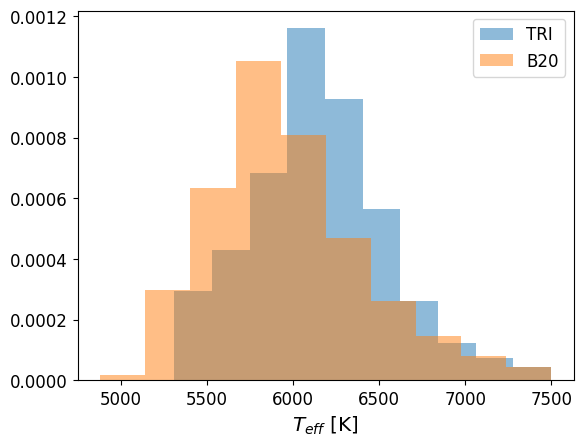

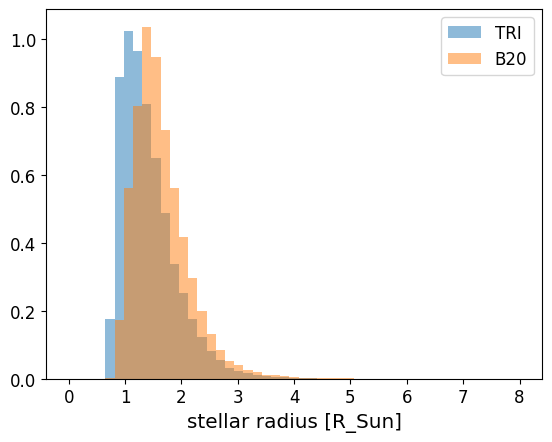

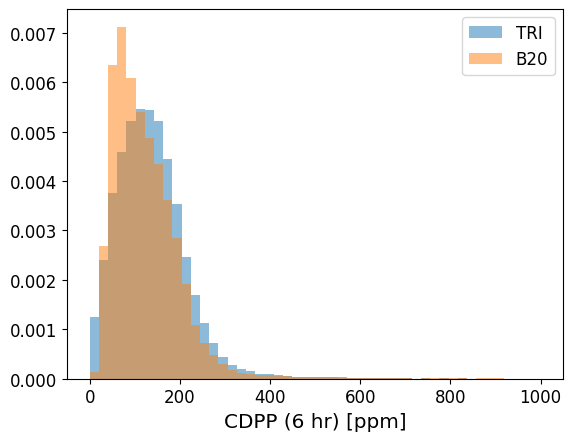

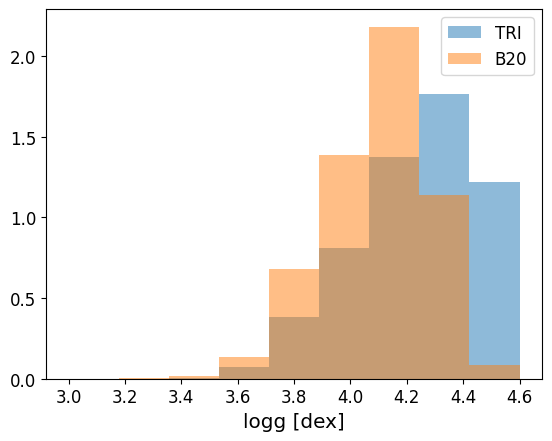

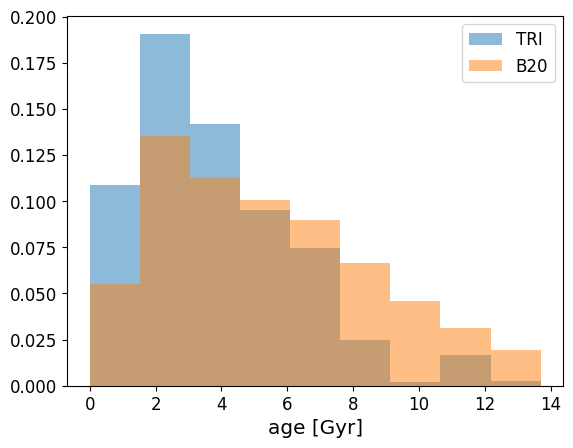

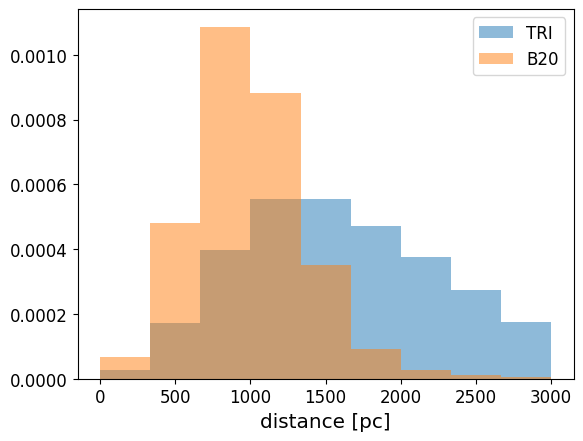

In [12]:
#"""
### PLOT SINGLE PARAMETER DISTRIBUTIONS
#plt.hist(trilegal_kepler['logL'], label='TRI', alpha=0.5, density=True)
#plt.hist(matched_trilegal['logL'], label='matched TRI', alpha=0.5, density=True)
#plt.hist(berger_kepler['iso_lum'], label='B20', alpha=0.5, density=True)
#plt.xlabel(r'log luminosity [$ℒ_{\odot}$ ]')
#plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_lum_distributions.png')
#plt.show()

plt.hist(trilegal_kepler['Teff'], label='TRI', alpha=0.5, density=True)
#plt.hist(matched_trilegal['Teff'], label='matched TRI', alpha=0.5, density=True)
plt.hist(berger_kepler['iso_teff'], label='B20', alpha=0.5, density=True)
plt.xlabel(r'$T_{eff}$ [K]')
plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_teff_distributions.png')
plt.show()

#plt.hist(trilegal_kepler.iloc[:len(berger_kepler)+20000]['stellar_radius'], alpha=0.5, label='TRI', bins=np.linspace(0, 8, 50))
plt.hist(trilegal_kepler['stellar_radius'], alpha=0.5, label='TRI', bins=np.linspace(0, 8, 50), density=True)
#plt.hist(matched_trilegal['stellar_radius'], alpha=0.5, label='matched TRI', bins=np.linspace(0, 8, 50), density=True)
plt.hist(berger_kepler['iso_rad'], alpha=0.5, label='B20', bins=np.linspace(0, 8, 50), density=True)
plt.xlabel('stellar radius [R_Sun]')
plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_radius_distributions.png')
plt.show()

#plt.hist(trilegal_kepler['Mact'], alpha=0.5, label='TRI', bins=np.linspace(0, 3, 50), density=True)
#plt.hist(matched_trilegal['Mact'], alpha=0.5, label='matched TRI', bins=np.linspace(0, 3, 50), density=True)
#plt.hist(berger_kepler['iso_mass'], alpha=0.5, label='B20', bins=np.linspace(0, 3, 50), density=True)
#plt.xlabel(r'$M_{*}$ [$M_{\odot}$]')
#plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_mass_distributions.png')
#plt.show()

plt.hist(trilegal_kepler['cdpp'], alpha=0.5, label='TRI', bins=np.linspace(0, 1000, 50), density=True)
#plt.hist(matched_trilegal['cdpp'], alpha=0.5, label='matched TRI', bins=np.linspace(0, 1000, 50), density=True)
plt.hist(berger_kepler['rrmscdpp06p0'], alpha=0.5, label='B20', bins=np.linspace(0, 1000, 50), density=True)
plt.xlabel('CDPP (6 hr) [ppm]')
plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_cdpp_distributions.png')
plt.show()

plt.hist(trilegal_kepler['logg'], alpha=0.5, label='TRI', bins=np.linspace(3., 4.6, 10), density=True)
#plt.hist(matched_trilegal['logg'], alpha=0.5, label='matched TRI', bins=np.linspace(3., 4.6, 10), density=True)
plt.hist(berger_kepler['iso_logg'], alpha=0.5, label='B20', bins=np.linspace(3., 4.6, 10), density=True)
plt.xlabel('logg [dex]')
plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_logg_distributions.png')
plt.show()

plt.hist(trilegal_kepler['age'], alpha=0.5, label='TRI', bins=np.linspace(0., 13.7, 10), density=True)
#plt.hist(matched_trilegal['age'], alpha=0.5, label='matched TRI', bins=np.linspace(0., 13.7, 10), density=True)
plt.hist(berger_kepler['iso_age'], alpha=0.5, label='B20', bins=np.linspace(0., 13.7, 10), density=True)
plt.xlabel('age [Gyr]')
plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_age_distributions.png')
plt.show()

plt.hist(trilegal_kepler['distance_pc'], alpha=0.5, label='TRI', bins=np.linspace(0, 3000, 10), density=True)
#plt.hist(matched_trilegal['age'], alpha=0.5, label='matched TRI', bins=np.linspace(0, 3000, 10), density=True)
plt.hist(berger_kepler['dist'], alpha=0.5, label='B20', bins=np.linspace(0, 3000, 10), density=True)
plt.xlabel('distance [pc]')
plt.legend()
#plt.savefig(path+'plots/trilegal/stellar_distance_distributions.png')
plt.show()
#"""

In [13]:
# bonus age cuts
trilegal_kepler = trilegal_kepler.loc[trilegal_kepler['age'] <= 8.]

berger_kepler['age'] = berger_kepler['iso_age']
berger_kepler = berger_kepler.loc[berger_kepler['age'] <= 8.]

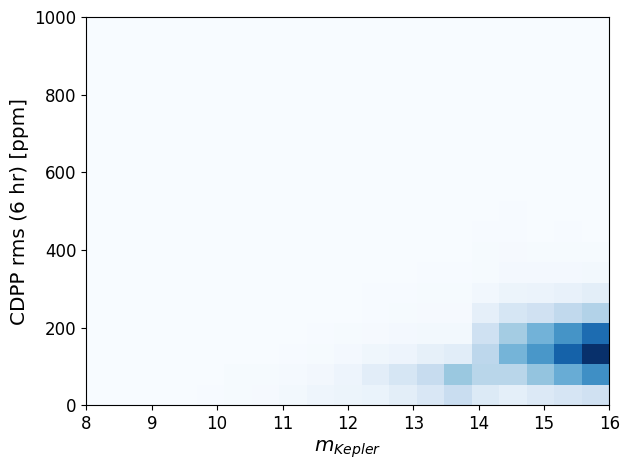

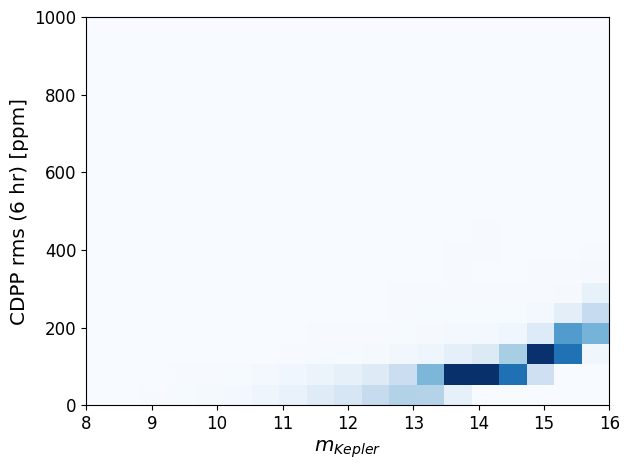

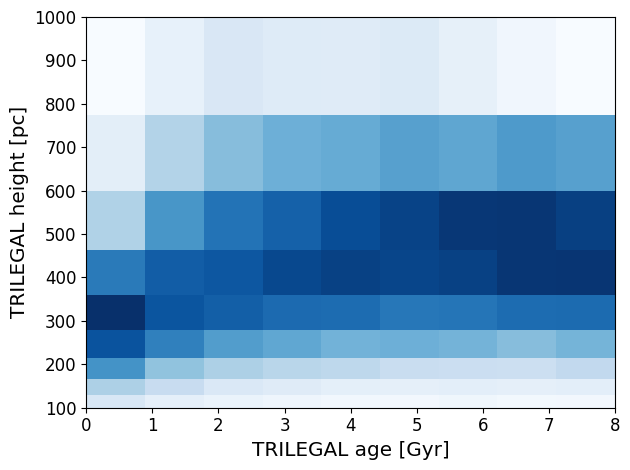

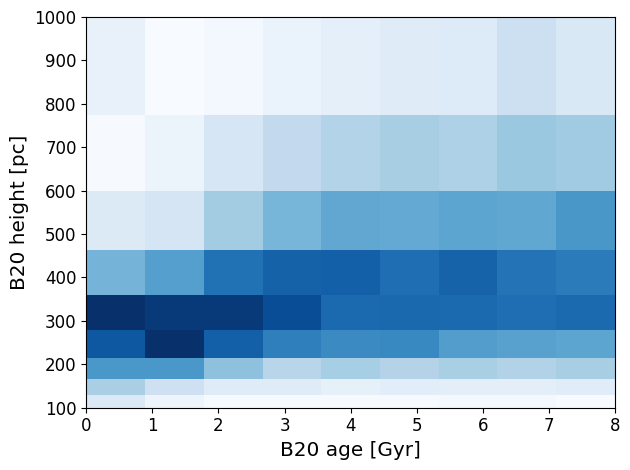

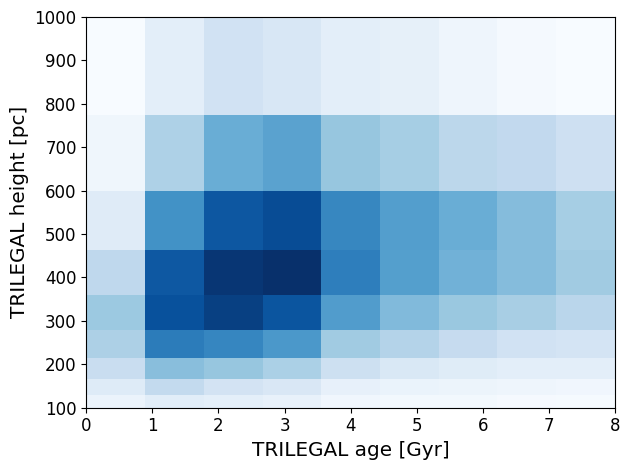

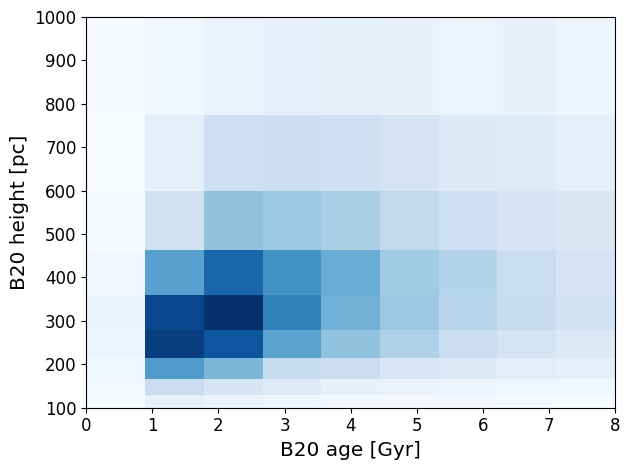

In [14]:
### MORE DIAGNOSTIC PLOTS: KEPMAG VS CDPP, AND AGE VS HEIGHT
#"""
ax = utils.plot_kepmag_vs_cdpp_heatmap(trilegal_kepler, label='TRI') # matched_trilegal
#plt.savefig(path+'plots/kepmag_vs_cdpp_tri.png')
plt.show()
ax = utils.plot_kepmag_vs_cdpp_heatmap(berger_kepler, label='B20')
#plt.savefig(path+'plots/kepmag_vs_cdpp_b20.png')
plt.show()
ax = utils.plot_age_vs_height(trilegal_kepler, label='TRI', normalized=True)
#plt.savefig(path+'plots/age_vs_height_tri_norm.png')
plt.show()
ax = utils.plot_age_vs_height(berger_kepler, label='B20', normalized=True)
#plt.savefig(path+'plots/age_vs_height_b20_norm.png')
plt.show()
ax = utils.plot_age_vs_height(trilegal_kepler, label='TRI', normalized=False)
#plt.savefig(path+'plots/age_vs_height_tri.png')
plt.show()
ax = utils.plot_age_vs_height(berger_kepler, label='B20', normalized=False)
#plt.savefig(path+'plots/age_vs_height_b20.png')
plt.show()
#"""



With diagnostic plots out of the way, we can determine if we are satisfied to proceed with forward modeling. If so, let's choose some fiducial hyperparameters first.

In [15]:
# Zhu+18 planet host fraction
#f = 0.3
#f_err = 0.03

# planet formation history model parameters
threshold = 9.5 # cosmic age in Gyr
frac1 = 0.15 # frac1 must be < frac2 if comparing cosmic ages and not stellar ages
frac2 = 0.70

name_thresh = 95
name_f1 = 15
name_f2 = 70
name = 'step_'+str(name_thresh)+'_'+str(name_f1)+'_'+str(name_f2)
#name = 'monotonic_'+str(name_f1)+'_'+str(name_f2)
name = 'piecewise_'+str(name_thresh)+'_'+str(name_f1)+'_'+str(name_f2)

trilegal_kepler = trilegal_kepler.reset_index()

# make columns uniform for convenience
trilegal_kepler['stellar_mass'] = trilegal_kepler['Mact']
berger_kepler['cdpp'] = berger_kepler['rrmscdpp06p0']

In [16]:
height_bins = np.logspace(2, 3, 6)
num_files = 3 # change this to create more realizations of stellar and planetary populations

def create_files(df, num_files, threshold, frac1, frac2, label, f=0.3, f_err=0.03):
    for j in tqdm(range(num_files)): 

        if label=='B20':
            # draw stellar radius, mass, and age using asymmetric errors 
            df_temp = simulate_helpers.draw_asymmetrically(df, 'iso_rad', 'iso_rad_err1', 'iso_rad_err2', 'stellar_radius')
            df_temp = simulate_helpers.draw_asymmetrically(df_temp, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
            df_temp = simulate_helpers.draw_asymmetrically(df_temp, 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'stellar_mass')
            df_temp = simulate_helpers.draw_asymmetrically(df_temp, 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'Teff')

        elif label=='TRI':
            df_temp = df
            
        ### create a Population object to hold information about the occurrence law governing that specific population
        pop = Population(df_temp['age'], threshold, frac1, frac2)
        #frac_hosts = pop.galactic_occurrence_step(threshold, frac1, frac2)
        #frac_hosts = pop.galactic_occurrence_monotonic(frac1, frac2)
        frac_hosts = pop.galactic_occurrence_piecewise(frac1, frac2, threshold)
        #frac_hosts = np.random.normal(f,f_err,len(df_temp)) # use this when holding planet host fraction constant; using Zhu+18 values
        intact_fracs = scipy.stats.truncnorm.rvs(0, 1, loc=0.18, scale=0.1, size=len(df_temp))  # use this when holding intact fraction constant; using Lam+Ballard24 values
        #intact_fracs = pop.galactic_occurrence_intact(threshold, frac1, frac2)
        
        # radius valley power law envelope slopes
        alpha_se = np.random.normal(-1., 0.2)
        alpha_sn = np.random.normal(-1.5, 0.1)
    
        # create Star objects, with their planetary systems
        star_data = []
        for i in range(len(df_temp)): 
            star = Star(df_temp['age'][i], df_temp['stellar_radius'][i], df_temp['stellar_mass'][i], df_temp['Teff'][i], df_temp['cdpp'][i], df_temp['height'][i], alpha_se, alpha_sn, frac_hosts[i], intact_fracs[i])
            star_update = {
                'kepid': star.kepid,
                'age': star.age,
                'stellar_radius': star.stellar_radius,
                'stellar_mass': star.stellar_mass,
                'rrmscdpp06p0': star.rrmscdpp06p0,
                'frac_host': star.frac_host,
                'height': star.height,
                'midplane': star.midplane,
                'status': star.status,
                'sigma_incl': star.sigma_incl,
                'num_planets': star.num_planets,
                'periods': star.periods,
                'incls': star.incls,
                'mutual_incls': star.mutual_incls,
                'eccs': star.eccs,
                'omegas': star.omegas,
                'planet_radii': star.planet_radii,
                'prob_intact': star.prob_intact
            }
            star_data.append(star_update)
            pop.add_child(star)
    
        # convert back to DataFrame
        #j = 0
        df_all = pd.DataFrame.from_records(star_data)
        """
        ### debug uniform intact frac
        ones = trilegal_kepler_all.loc[trilegal_kepler_all.num_planets == 1]
        twos = trilegal_kepler_all.loc[trilegal_kepler_all.num_planets == 2]
        fives = trilegal_kepler_all.loc[trilegal_kepler_all.num_planets == 5]
        sixes = trilegal_kepler_all.loc[trilegal_kepler_all.num_planets == 6]
        print("avg age by multiplicity")
        print(np.nanmean(ones.age))
        print(np.nanmean(twos.age))
        print(np.nanmean(fives.age))
        print(np.nanmean(sixes.age))
    
        print("avg height by multiplicity")
        print(np.nanmean(ones.height))
        print(np.nanmean(twos.height))
        print(np.nanmean(fives.height))
        print(np.nanmean(sixes.height))
    
        print("avg age intact vs disrupted")
        intact = trilegal_kepler_all.loc[trilegal_kepler_all.status == 'intact']
        disrupted = trilegal_kepler_all.loc[trilegal_kepler_all.status == 'disrupted']
        print(np.nanmean(intact['age']))
        print(np.nanmean(disrupted['age']))
    
        print("avg prob_intact intact vs disrupted")
        print(np.nanmean(intact['prob_intact']))
        print(np.nanmean(disrupted['prob_intact']))
        print(np.nanmean(trilegal_kepler_all.prob_intact))
        #plt.scatter(trilegal_kepler_all.num_planets, trilegal_kepler_all.age) # yikes
        #plt.show()
    
        print("avg prob intact by height")
        low = trilegal_kepler_all.loc[trilegal_kepler_all.height <= 250]
        medium = trilegal_kepler_all.loc[(trilegal_kepler_all.height <= 500) & (trilegal_kepler_all.height > 250)]
        high = trilegal_kepler_all.loc[trilegal_kepler_all.height > 500]
        print(np.nanmean(low['prob_intact']), len(low))
        print(np.nanmean(medium['prob_intact']), len(medium))
        print(np.nanmean(high['prob_intact']), len(high))
    
        print("avg age by height")
        print(np.nanmean(low['age']))
        print(np.nanmean(medium['age']))
        print(np.nanmean(high['age']))
    
        print("avg occurrence by height")
        trilegal_kepler_planets = trilegal_kepler_all.loc[trilegal_kepler_all['num_planets'] > 0]
        low_planets = trilegal_kepler_planets.loc[trilegal_kepler_planets.height <= 250]
        medium_planets = trilegal_kepler_planets.loc[(trilegal_kepler_planets.height <= 500) & (trilegal_kepler_planets.height > 250)]
        high_planets = trilegal_kepler_planets.loc[trilegal_kepler_planets.height > 500]
        print(np.sum(low_planets.num_planets)/len(low))
        print(np.sum(medium_planets.num_planets)/len(medium))
        print(np.sum(high_planets.num_planets)/len(high))
        """
    
        # gotta make corresponding directories first if you want to put these files here. Otherwise, change path as you see fit. 
        if label=='B20':
            df_all.to_csv(path+'data/berger_gala2/'+name+'/'+name+'_'+str(j)+'.csv')
        if label=='TRI':
            df_all.to_csv(path+'data/trilegal2/'+name+'/'+name+'_'+str(j)+'.csv')


In [8]:
create_files(berger_kepler, 5, threshold, frac1, frac2, label='B20')

  0%|                                                                                                                                        | 0/5 [00:00<?, ?it/s]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will r

mean f:  0.28464875


/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
 20%|█████████████████████████▌                                                                                                      | 1/5 [00:53<03:33, 53.38s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will r

mean f:  0.28464875


 40%|███████████████████████████████████████████████████▏                                                                            | 2/5 [01:46<02:39, 53.07s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simula

mean f:  0.28464875


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 3/5 [02:39<01:46, 53.21s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simula

mean f:  0.28464875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4/5 [03:32<00:53, 53.12s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:1059: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[drawn] = df[drawn].fillna(method='ffill')
/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simula

mean f:  0.28464875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:26<00:00, 53.32s/it]


In [17]:
create_files(trilegal_kepler, 5, threshold, frac1, frac2, label='TRI')

  0%|                                                                                                                                        | 0/5 [00:00<?, ?it/s]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))


mean f:  0.3296349


 20%|█████████████████████████▌                                                                                                      | 1/5 [00:26<01:45, 26.43s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))


mean f:  0.3296349


 40%|███████████████████████████████████████████████████▏                                                                            | 2/5 [00:52<01:18, 26.19s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))


mean f:  0.3296349


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 3/5 [01:18<00:52, 26.08s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))


mean f:  0.3296349


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4/5 [01:43<00:25, 25.84s/it]/Users/chrislam/anaconda3/envs/sculpting/lib/python3.12/site-packages/psps/simulate_helpers.py:960: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))


mean f:  0.3296349


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.86s/it]


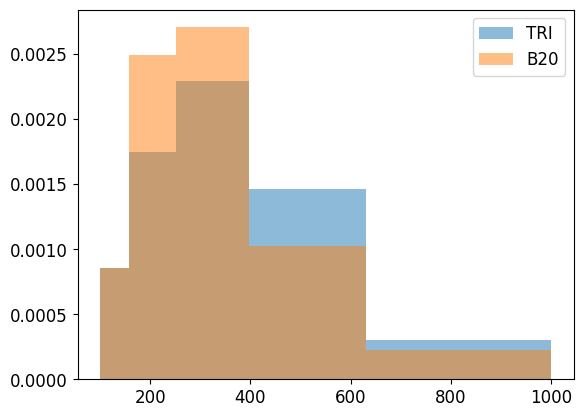

In [26]:
plt.hist(trilegal_kepler.height, alpha=0.5, label='TRI', bins=np.logspace(2, 3, 6), density=True)
plt.hist(berger_kepler.height, alpha=0.5, label='B20', bins=np.logspace(2, 3, 6), density=True)
plt.legend()
plt.show()